# Weather Compensation Control

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']

In [3]:
# Heat demand calculation function
def calculate_heat_loss_space(K, indoor_temp, outdoor_temp): 
    return K * (indoor_temp - outdoor_temp)

def calculate_heat_loss_water(K, flow_temp, indoor_temp): 
    return K * (flow_temp - indoor_temp)

# Flow temperature calculation function
def calculate_target_flow_temp(lower_temp, upper_temp, lower_flow, upper_flow, outdoor_temp):
    """Heating Curve Calculation

    Args:
        lower_temp (float): lower outdoor temperature
        upper_temp (float): upper outdoor temperature
        lower_flow (float): lower flow temperature
        upper_flow (float): upper flow temperature
        outdoor_temp (float): outdoor temperature
    """
    if outdoor_temp < lower_temp:
        return upper_flow
    elif outdoor_temp > upper_temp:
        return lower_flow
    else:
        return lower_flow + ((upper_flow - lower_flow) / (upper_temp - lower_temp)) * (upper_temp - outdoor_temp)

In [4]:
# Constants for the building and heating system
TARGET_INDOOR_TEMP = 20.0  # Target indoor temperature (°C)

# Heat loss coefficient
K_SH = 0.02 # Heat loss coefficient for space heating (kW/°C)

K_water = 0.02 # Heat loss coefficient for water heating (kW/°C)

# base_flow_temp = 30  # Minimum flow temperature for heating system (°C)


# Heat pump operation threshold (hysteresis control to prevent rapid cycling)
operation_margin = 1.0  # Margin in degrees for switching heat pump on/off

# # Simulation parameters
# num_days = 7  # Length of simulation in days
# hours_per_day = 24
# total_hours = num_days * hours_per_day

# Define heating curve parameters
lower_outdoor_temp = -1  # Lower outdoor temperature for heating curve (°C)
upper_outdoor_temp = TARGET_INDOOR_TEMP  # Upper outdoor temperature for heating curve (°C)
lower_flow_temp = 30     # Lower flow temperature for heating curve (°C)
upper_flow_temp = 55     # Upper flow temperature for heating curve (°C)  

# Building heat demand calculation parameters
c_water = 4186.0            # Specific heat capacity of water in J/kg.K
rho_water = 1000.0          # Density of water in kg/m^3
flow_rate = 400            # Flow rate in kg/30min (assumed constant for simplicity)

# Time step in hours
delta_t = 0.5

# Initialize lists to store results
heat_demands = []
target_flow_temps = []
heat_pump_status = []
current_flow_temp = 45  # Initialize current flow temperature
current_flow_temps = []



# Simulate each hour in the time period
for outdoor_temp in outdoor_temp_series:
    
    if outdoor_temp >= TARGET_INDOOR_TEMP:
        heat_pump_status.append("Off")
        heat_demand = 0
        target_flow_temp = lower_flow_temp
        current_flow_temp = target_flow_temp
        current_flow_temps.append(current_flow_temp)
        target_flow_temps.append(target_flow_temp)
    else:
        # Calculate the target flow temperature based on heat demand and outdoor temperature
        target_flow_temp = calculate_target_flow_temp(lower_temp=lower_outdoor_temp, 
                                                        upper_temp=upper_outdoor_temp, 
                                                        lower_flow=lower_flow_temp, 
                                                        upper_flow=upper_flow_temp, 
                                                        outdoor_temp=outdoor_temp)
        target_flow_temps.append(target_flow_temp)
        current_flow_temps.append(current_flow_temp)
        
        # Heat pump operation control logic
        if current_flow_temp <= target_flow_temp - operation_margin:
            heat_pump_status.append("On")
            
            heat_demand = (calculate_heat_loss_space(K_SH, TARGET_INDOOR_TEMP, outdoor_temp) + (c_water * flow_rate * (target_flow_temp - current_flow_temp))/3.6e6)/delta_t
            # heat_demand = ((c_water * flow_rate * (target_flow_temp - current_flow_temp))/3.6e6)/delta_t
            current_flow_temp = target_flow_temp  # Flow temp rises to target as pump is on
        elif current_flow_temp >= target_flow_temp + operation_margin:
            heat_pump_status.append("Off")
            current_flow_temp -= (calculate_heat_loss_water(K_SH, current_flow_temp, TARGET_INDOOR_TEMP) * 3.6e6)/(c_water * flow_rate)  # Flow temp decreases to target as pump is off 
            heat_demand = 0
        else:
            # Maintain previous state to avoid rapid cycling if within margin
            heat_pump_status.append(heat_pump_status[-1])
            if heat_pump_status[-1] == "On":
                
                heat_demand = (calculate_heat_loss_space(K_SH, TARGET_INDOOR_TEMP, outdoor_temp) + (c_water * flow_rate * (target_flow_temp + operation_margin - current_flow_temp))/3.6e6)/delta_t
                # heat_demand = ((c_water * flow_rate * (target_flow_temp + operation_margin - current_flow_temp))/3.6e6)/delta_t
                
                current_flow_temp = target_flow_temp + operation_margin
            else:
                current_flow_temp -= (calculate_heat_loss_water(K_SH, current_flow_temp, TARGET_INDOOR_TEMP) * 3.6e6)/(c_water * flow_rate)
                heat_demand = 0

    heat_demands.append(heat_demand)


In [5]:
# Create a DataFrame to store the results
simulation_data = pd.DataFrame({
    "Date": df["Date"],
    "Outdoor Temperature (°C)": outdoor_temp_series,
    "Heat Demand (kW)": heat_demands,
    "Flow Temperature (°C)": current_flow_temps,
    "Target Flow Temperature (°C)": target_flow_temps,
    "Heat Pump Status": heat_pump_status
})

In [6]:
simulation_data['Heat Demand (kWh)'] = simulation_data['Heat Demand (kW)'] * delta_t
simulation_data.to_csv("simulation_results_weather_compensation.csv", index=False)

# Visualisation

In [7]:
simulation_data['Date'] = pd.to_datetime(simulation_data['Date'], format='%Y-%m-%d %H:%M:%S')
simulation_data.set_index('Date', inplace=True)

In [8]:
simulation_data.head()

,Outdoor Temperature (°C),Heat Demand (kW),Flow Temperature (°C),Target Flow Temperature (°C),Heat Pump Status,Heat Demand (kWh)
Date,,,,,,
2023-01-01 00:00:00,5.5,2.684074,45.000000,47.261905,On,1.342037
2023-01-01 00:30:00,5.5,1.510222,47.261905,47.261905,On,0.755111
2023-01-01 01:00:00,5.5,0.000000,48.261905,47.261905,Off,0.000000
2023-01-01 01:30:00,5.5,0.000000,47.046629,47.261905,Off,0.000000
2023-01-01 02:00:00,5.5,1.862119,45.883611,47.261905,On,0.931060


## Annual half hourly profile

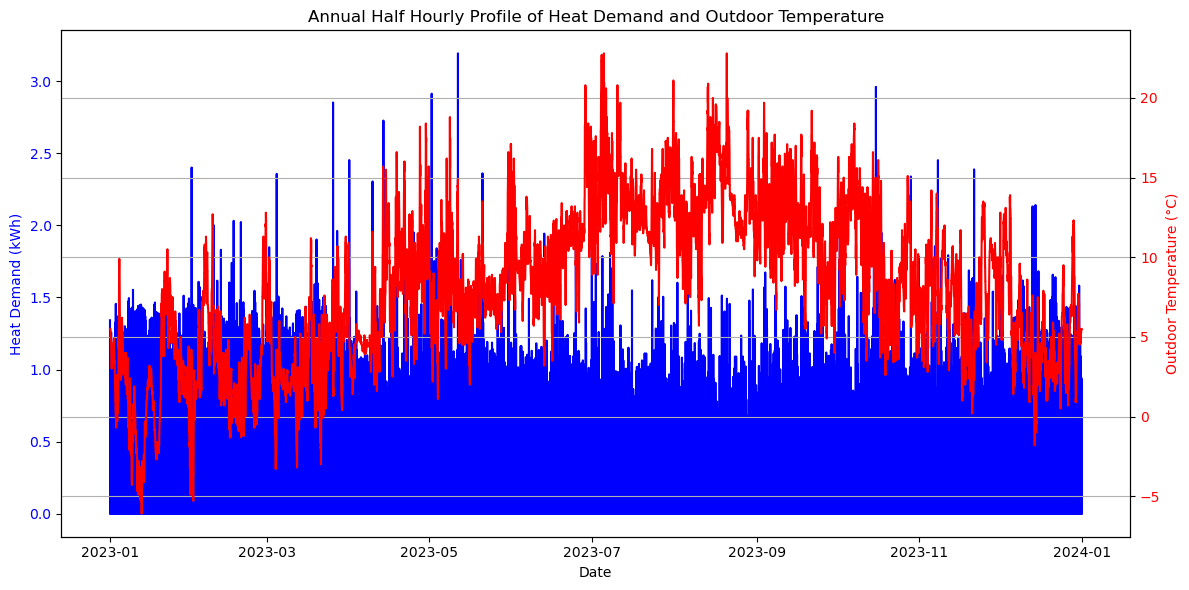

In [9]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(simulation_data.index, simulation_data['Heat Demand (kWh)'], label='Hourly Heating Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(simulation_data.index, simulation_data['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Half Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_half_hourly_profile_weather_compensation.pdf')
plt.show()

## Annual hourly profile

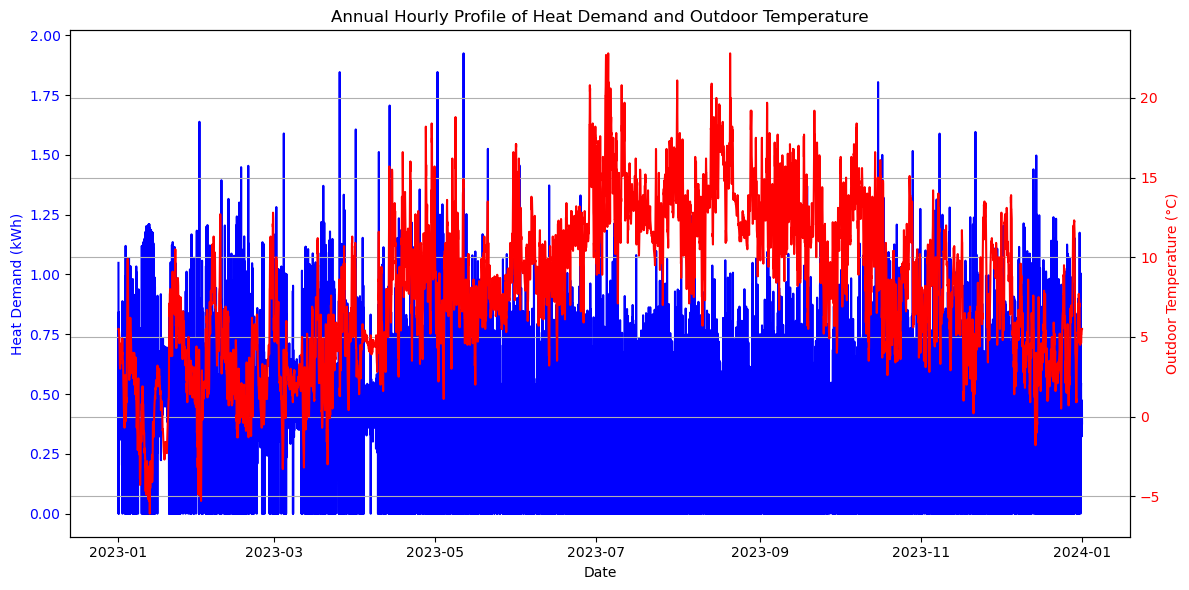

In [10]:
# Resample to hourly frequency and calculate the mean
numeric_df = simulation_data.select_dtypes(include='number')
hourly_df = numeric_df.resample('h').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(hourly_df.index, hourly_df['Heat Demand (kWh)'], label='Hourly Heating Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(hourly_df.index, hourly_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_hourly_profile_weather_compensation.pdf')
plt.show()

## Daily hourly profile

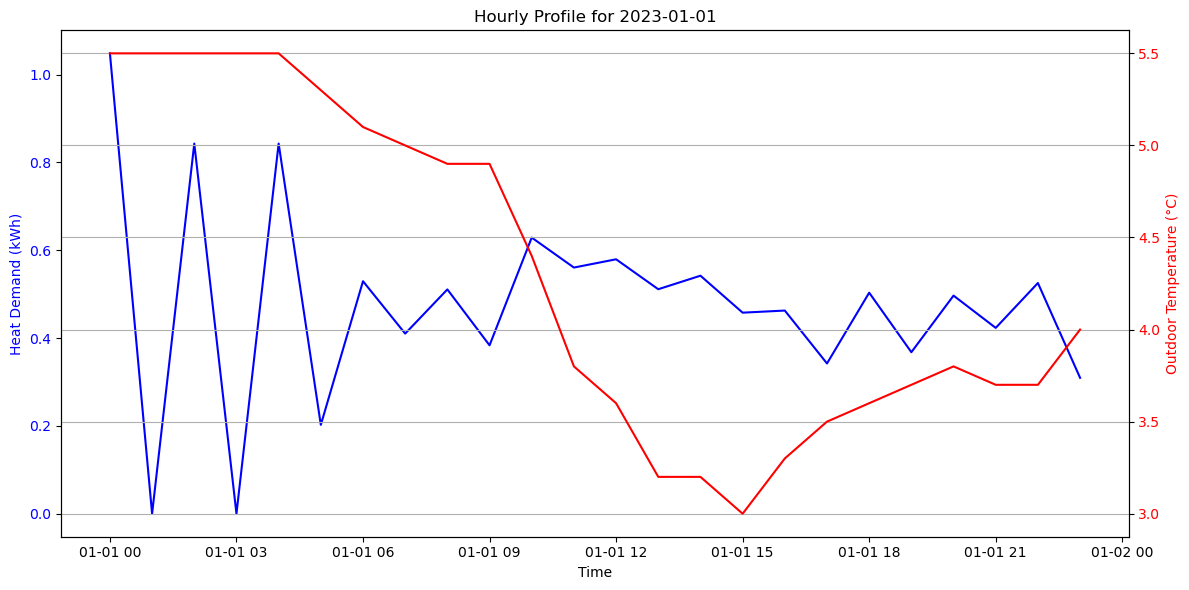

In [11]:
# Specify the day you want to plot
specific_day = '2023-01-01'  # Change this to the desired date

# Filter the data for the specific day
daily_profile = hourly_df.loc[specific_day]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(daily_profile.index, daily_profile['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_profile.index, daily_profile['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Hourly Profile for {specific_day}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/hourly_profile_{specific_day}_weather_compensation.pdf')
plt.show()

## Annual daily profile

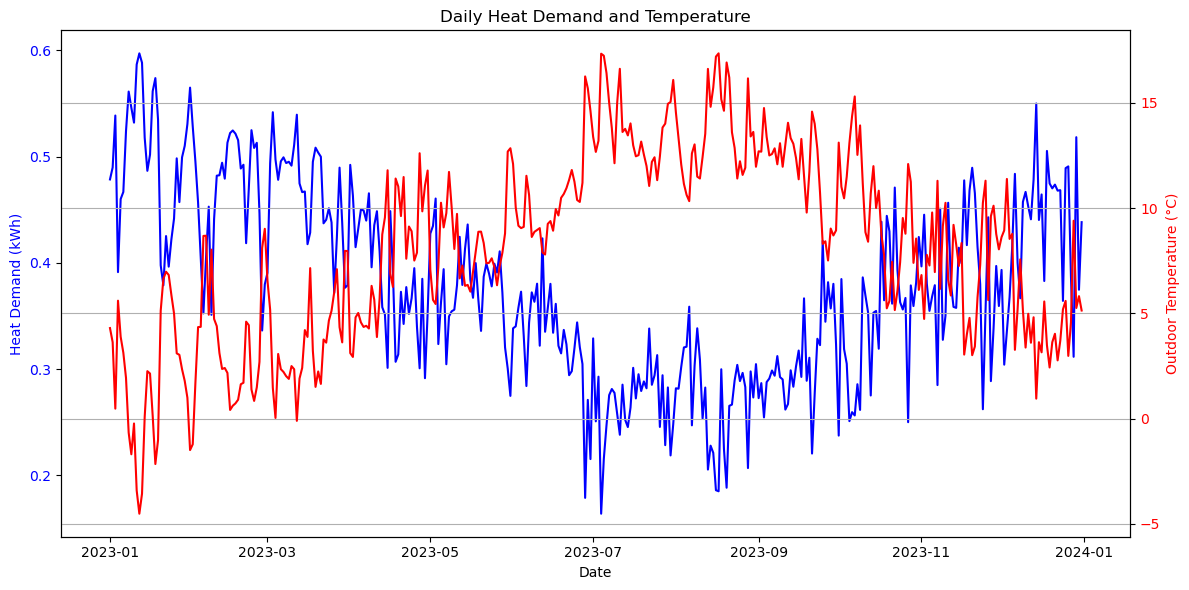

In [12]:
daily_df = numeric_df.resample('D').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(daily_df.index, daily_df['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_df.index, daily_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Daily Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_daily_profile_weather_compensation.pdf')
plt.show()

## Monthly daily profile

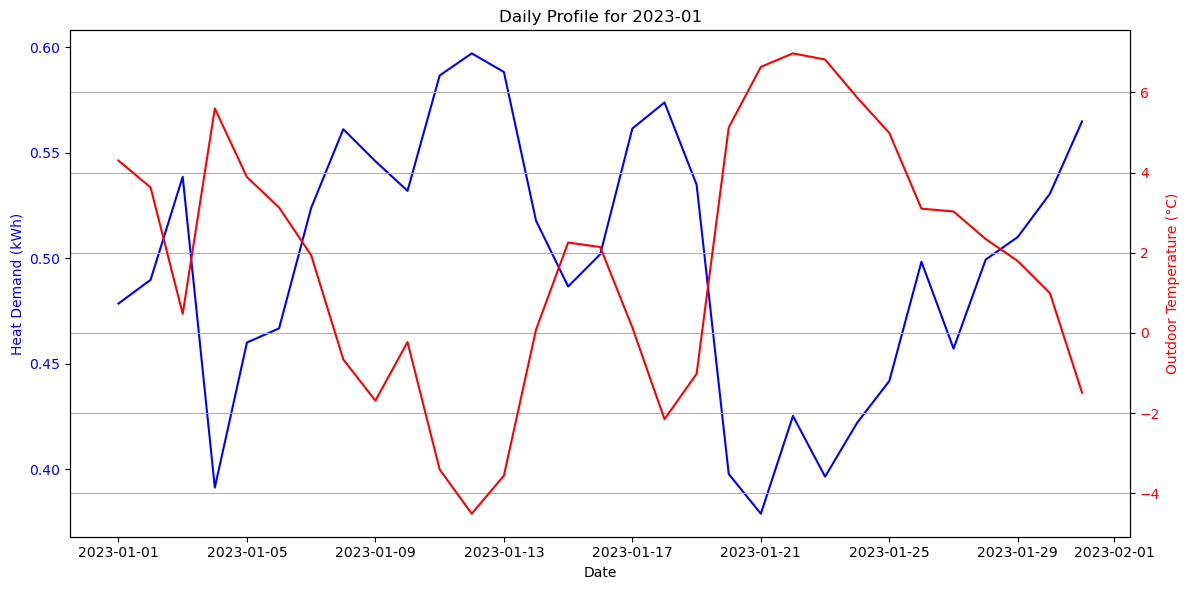

In [13]:
# Specify the month you want to plot
specific_month = '2023-01'  # Change this to the desired month

# Filter the data for the specific month
monthly_profile = daily_df.loc[specific_month]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(monthly_profile.index, monthly_profile['Heat Demand (kWh)'], label='Daily Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_profile.index, monthly_profile['Outdoor Temperature (°C)'], label='Daily Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Daily Profile for {specific_month}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/monthly_profile_{specific_month}_weather_compensation.pdf')
plt.show()